In [1]:
#import warnings
#warnings.filterwarnings('ignore')

#sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
        GradientBoostingClassifier, StackingClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

#sklearn metrics
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve
#DOES NOT WORK: , plot_precision_recall_curve
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#sklearn model selection
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, cross_val_predict

#scikit-plot
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_confusion_matrix
from scikitplot.estimators import plot_learning_curve

#mlxtend
from mlxtend.plotting import plot_learning_curves, plot_decision_regions


#hyperparameter tuning

#miscellaneous
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#some "global" variables defined here
random_state_num = 0 
cv_num = 10
classes_num = 2 #there are two classes, non-negative (0) and negative (1)
fig_size_tuple = (15,7)
title_fontsize_num = 15
label_fontsize_num = 12

# Read Trained Word2Vec Embedding Vectors and Engineered Features
We read in the engineered features dataset as a dataframe.

In [2]:
#read the csv of engineered features
#then split the columns into 
df_gensim_word2vec_features = pd.read_csv('..\data\gensim_word2vec_trained_with_engineered_features.csv')
X = df_gensim_word2vec_features.loc[:, df_gensim_word2vec_features.columns != 'binary_response_variable']
Y= df_gensim_word2vec_features.loc[:, df_gensim_word2vec_features.columns == 'binary_response_variable']

# Split into Train and Test dataset
The dataset is then split into a train and test dataset. 

In [3]:
#Split into training set, and test set
# we do not need a validation set because we will be doing k-fold cross validation

#split into 0.7 training, and 0.3 testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = random_state_num)

#convert Y_train and Y_test into 1-d array so we don't get stupid warnings about needing a 1d array for Y, in cross_validate function
Y_train_1d = Y_train.values.ravel()
Y_test_1d = Y_test.values.ravel()

#convert Y_train and Y_test into numpy array
Y_train_np_array = Y_train.to_numpy()
Y_test_np_array = Y_test.to_numpy()

# Models
Here we define a set of "basic" models we use as benchmarks to see which model algorithm is better than the others. 

In [4]:
stacking_base_learners = [
    ('sbl_1', LogisticRegression(random_state = random_state_num, max_iter = 500, C=1, \
                                              class_weight={1: 0.4, 0: 0.6}, penalty='l1', solver='liblinear', )),
    ('sbl_2', KNeighborsClassifier(n_neighbors=3, )),
    ('sbl_3', DecisionTreeClassifier()),
    ('sbl_4', GaussianNB())
]

models = [  
# Hyperparameter tuned GBM model
#     GradientBoostingClassifier(random_state = random_state_num, min_samples_split=140, min_samples_leaf=14, \
#                                subsample=0.9, n_estimators=10, max_features='sqrt', max_depth=8, \
#                                loss='deviance', learning_rate=0.15000000000000002, criterion='friedman_mse')

    KNeighborsClassifier(n_neighbors=3, ),
    DecisionTreeClassifier(),
    SVC(C = 1000000, gamma = 'auto', kernel = 'rbf', probability=True),
    GaussianNB(),
    #increased max_iter because it failed to converge at 100
    LogisticRegression(random_state = random_state_num, max_iter = 500, C=1, class_weight={1: 0.4, 0: 0.6}, \
                       penalty='l1', solver='liblinear'),
    AdaBoostClassifier(random_state = random_state_num),
    RandomForestClassifier(random_state = random_state_num),
    GradientBoostingClassifier(random_state = random_state_num),
    BaggingClassifier(base_estimator=LogisticRegression(random_state = random_state_num, max_iter = 500, C=1, \
                                                        class_weight={1: 0.4, 0: 0.6}, penalty='l1', solver='liblinear')),
    StackingClassifier(estimators=stacking_base_learners, final_estimator=LogisticRegression())
]

# Hyperparameter Tuning
 
Hyperparameter tuning is the adjustment of various pre-execution parameters passed to our Machine Learning models that affect their training/execution. Here we use two automated methods of choosing from a wide set of specified parameters - Grid Search (which exhaustively tries all combinations of specified parameters) and Random Search (which tries randomly sampled combinations of parameters).

## Grid Search

Grid Search (exhaustive) hyperparameter tuning.

In [ ]:
%%script false --no-raise-error
# ^ disables this cell in jupyter notebook

from sklearn.model_selection import GridSearchCV

for model in models:
    model_name = model.__class__.__name__
       
    #----Logistic Regression Hyperparameter Tuning----
    
    if model_name == 'LogisticRegression':    
        
        penalty = ['l1', 'l2']
        C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
        class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
        solver = ['liblinear', 'saga']

        param_grid = dict(penalty=penalty,
                          C=C,
                          class_weight=class_weight,
                          solver=solver)

        grid = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='roc_auc',
                            verbose=1,
                            n_jobs=-1)
        grid_result = grid.fit(X_train, Y_train)
        print('Model Name: ', model_name)
        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)
        
        #----Gradient Boosting Hyperparameter Tuning----

    if model_name == 'GradientBoostingClassifier':    

        learning_rate = [0.15,0.1,0.05,0.01,0.005,0.001]
        n_estimators = [100,250,500,750,1000,1250,1500,1750]
        max_depth = [2,3,4,5,6,7]       

        param_grid = dict(learning_rate=learning_rate,
                          n_estimators=n_estimators,
                          max_depth=max_depth,)

        grid = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='roc_auc',
                            verbose=1,
                            n_jobs=-1)
        grid_result = grid.fit(X_train, Y_train)
        print('Model Name: ', model_name)
        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)

## Random Search

Random Search hyperparameter tuning.

In [ ]:
%%script false --no-raise-error
# ^ disables this cell in jupyter notebook

#exploration of specifying a range of values using numpy's logspace function. 
#Used to specify range of C values in logistic regression.

import numpy as np

np.set_printoptions(precision=10)
np.set_printoptions(suppress=True)

np.logspace(0, 4, num=10)

In [ ]:
%%script false --no-raise-error
# ^ disables this cell in jupyter notebook

from sklearn.model_selection import RandomizedSearchCV

for model in models:
    model_name = model.__class__.__name__
    
    print(model)
    if model_name == 'LogisticRegression':    
        
        penalty = ['l1', 'l2']
        C = np.logspace(0, 4, num=10)
        class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
        solver = ['liblinear', 'saga']
        
        param_distributions = dict(penalty=penalty,
                          C=C,
                          class_weight=class_weight,
                          solver=solver)

        random = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_distributions,
                                    scoring='roc_auc',
                                    verbose=1, n_jobs=-1,
                                    n_iter=100)
        random_result = random.fit(X_train, Y_train)

        print('Model Name: ', model_name)
        print('Best Score: ', random_result.best_score_)
        print('Best Params: ', random_result.best_params_)
        
    if model_name == 'GradientBoostingClassifier':    
        
        loss=["deviance"]
        learning_rate=np.linspace(0.05, 0.2, num=4)       
        max_depth=[3,5,8]
        max_features=["log2","sqrt"]
        criterion=["friedman_mse",  "mae"]
        subsample=[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0]
        n_estimators=[10]   
        
        param_distributions = dict(loss=loss,
                          learning_rate=learning_rate,
                        #  min_samples_split=min_samples_split,
                        #  min_samples_leaf=min_samples_leaf,
                          max_depth=max_depth,
                          max_features=max_features,
                          criterion=criterion,
                          subsample=subsample,
                          n_estimators=n_estimators)

        random = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_distributions,
                                    cv=3,
                                    scoring='roc_auc',
                                    verbose=1, 
                                    n_jobs=-1,
                                    n_iter=100)
        random_result = random.fit(X_train, Y_train)
        
        print('Model Name: ', model_name)
        print('Best Score: ', random_result.best_score_)
        print('Best Params: ', random_result.best_params_)

# Model Benchmarks using various metrics
Here we use different metrics to becnhmark the models we have defined above. Such metrics include balanced accuracy, precision, recall, F1, F2, and ROC-AUC. 

F2 is different than F1 because it places heavier emphasis on recall, rather than precision. This is useful in our case because according to our business problem, there is more value to be gained from correctly identifying tweets of negative sentiment (i.e. the positive cases, or "1s"). Therefore, the opposite holds true as well: there is a heavier cost from misclassifying tweets of negative sentiment as positive sentiment (i.e. we misclassify true positives as false negatives); in real life, this could mean a potential PR disaster. On the other hand, misclassifying tweets of positive sentiment as negative sentiment isn't as costly (i.e. we misclassify true negatives as false positives); in real life, this just means the HR department may have to look at more false positives than a ML algorithm that places equal emphasis on both precision and recall.

In [5]:
#custom f2 score
#this places higher value on recall than precision 
#i.e. a false negative has higher cost than a false positive
#(this makes sense: a negative tweet we don't catch classify us more than a positive tweet we don't classify)
f2_scorer = make_scorer(fbeta_score, beta=2)

#for the other scorers, we need to create scorers from scratch since we want to use a dictionary for f2_scorer under 'scoring'
balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
precision_scorer = make_scorer(precision_score)
recall_scorer = make_scorer(recall_score)
f1_scorer = make_scorer(f1_score)
roc_auc_scorer = make_scorer(roc_auc_score)

In [6]:
cv_result_entries = []

for model in models:
    model_name = model.__class__.__name__
    
       
    metrics_dict = cross_validate(
        model, 
        X_train, 
        Y_train_1d, 
        #scoring = ['balanced_accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
        scoring = {
            'balanced_accuracy': balanced_accuracy_scorer, 
            'precision': precision_scorer, 
            'recall': recall_scorer, 
            'f1': f1_scorer,
            'f2': f2_scorer,
            'roc_auc': roc_auc_scorer
        },
        cv = cv_num,
        n_jobs=-1
    )

#REMOVED grid search hyperparam tuning code    
#     penalty = ['l1', 'l2']
#     C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
#     class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
#     solver = ['liblinear', 'saga']

#     param_grid = dict(penalty=penalty,
#                       C=C,
#                       class_weight=class_weight,
#                       solver=solver)

#     grid = GridSearchCV(estimator=model,
#                         param_grid=param_grid,
#                         scoring='roc_auc',
#                         verbose=1,
#                         n_jobs=-1)
#     grid_result = grid.fit(X_train, Y_train)

#     print('Best Score: ', grid_result.best_score_)
#     print('Best Params: ', grid_result.best_params_)
    
    for metric_key in metrics_dict.keys():
        for fold_index, metric_score in enumerate(metrics_dict[metric_key]):
            cv_result_entries.append((model_name, fold_index, metric_key, metric_score))

#convert entries into a dataframe
df_cross_validate_results = pd.DataFrame(cv_result_entries, columns =['model_name', 'fold_index', 'metric_key', 'metric_score'])

In [7]:
#save all results to CSV for reference
df_cross_validate_results.to_csv('../data/df_cross_validate_results.csv')

# Plotting

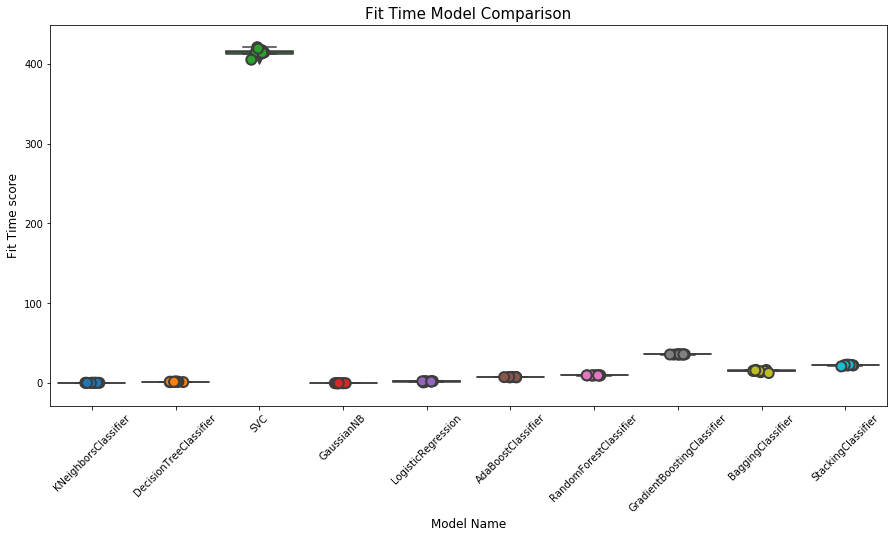

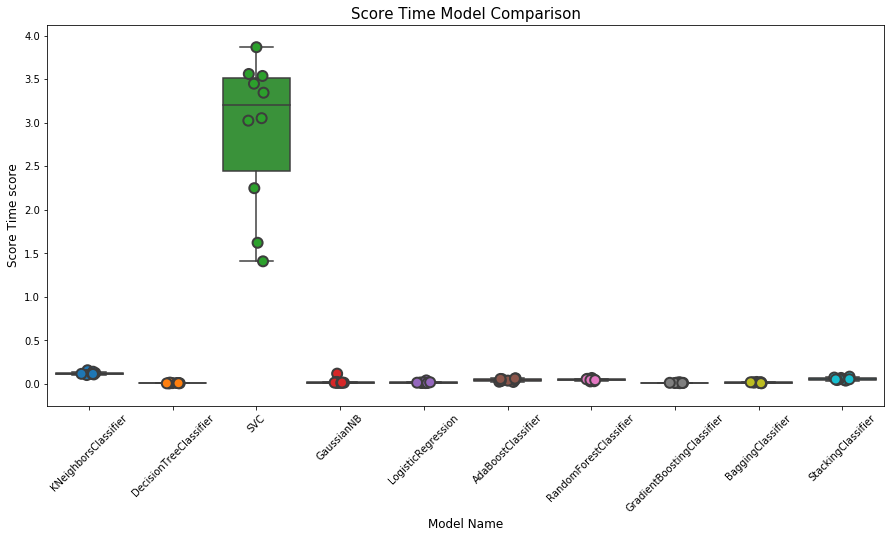

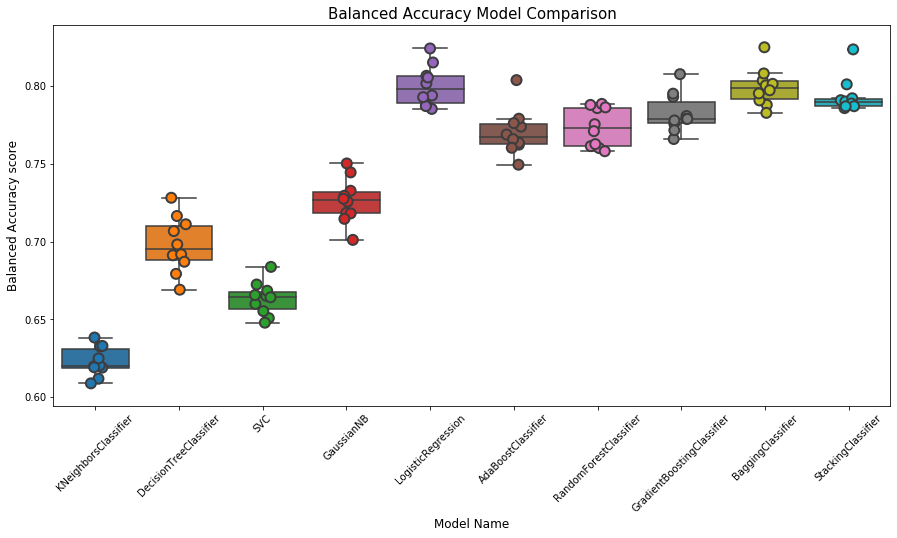

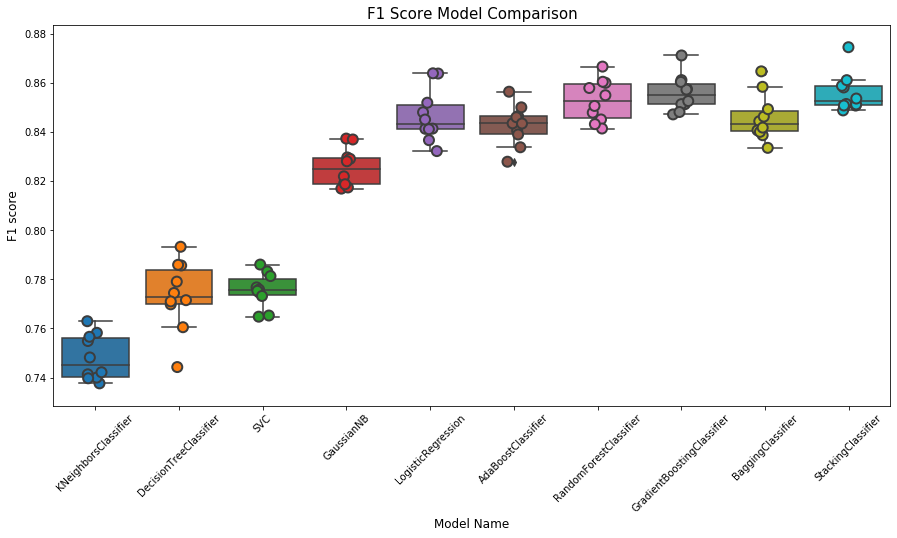

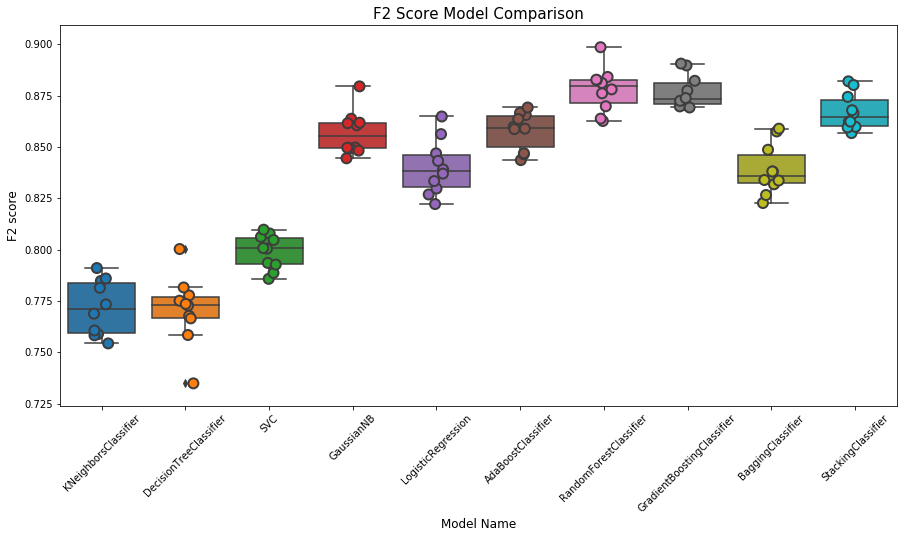

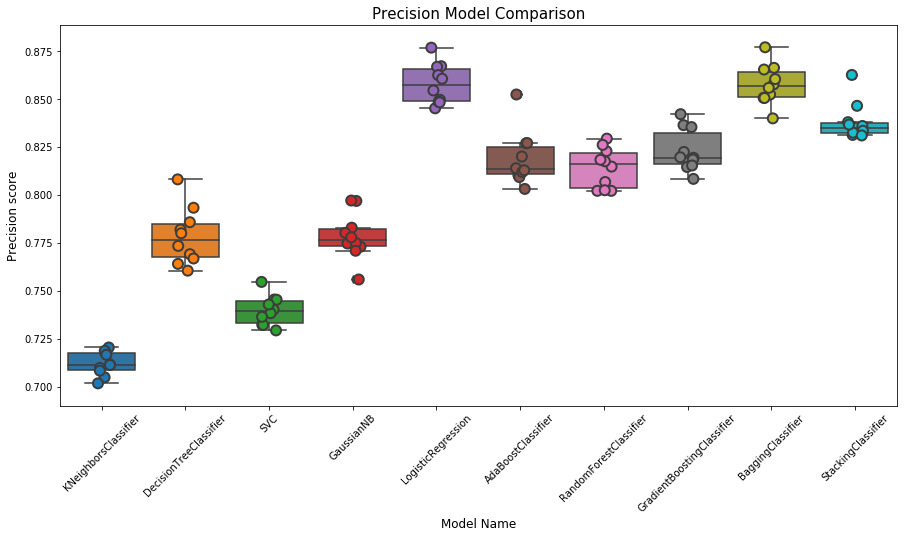

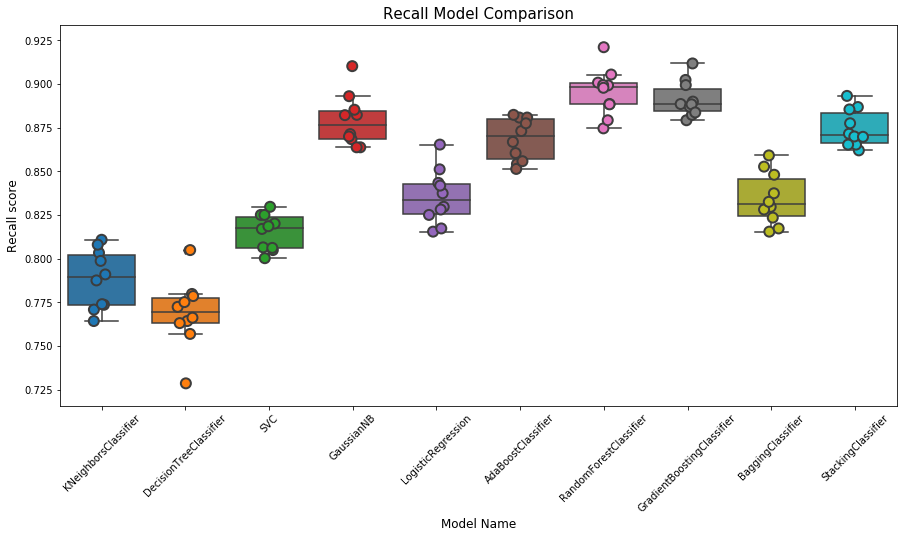

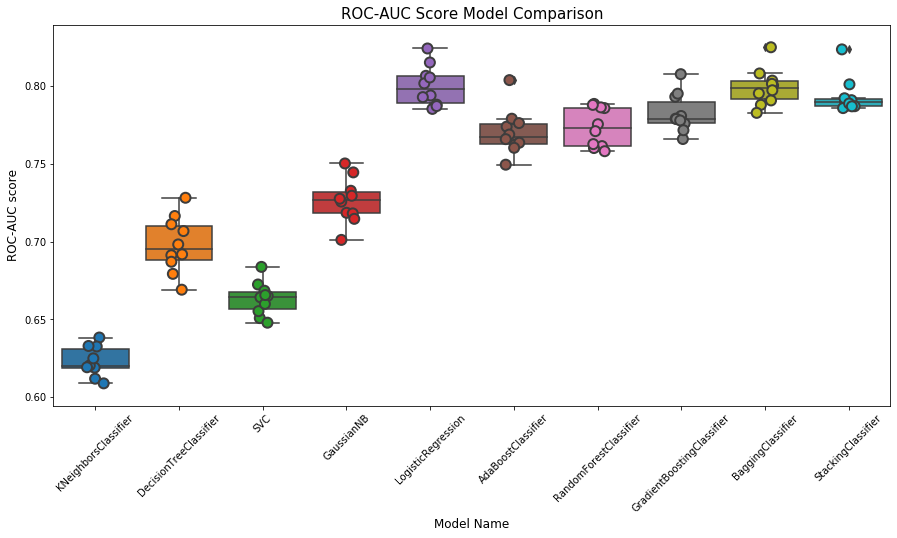

In [8]:
df_cv_results_fit_time = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'fit_time']
df_cv_results_score_time = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'score_time']
df_cv_results_balanced_acc = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_balanced_accuracy']
df_cv_results_precision = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_precision']
df_cv_results_recall = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_recall']
df_cv_results_f1 = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_f1']
df_cv_results_f2 = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_f2']
df_cv_results_roc_auc = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_roc_auc']


plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_fit_time)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_fit_time, size=10, linewidth=2)
plt.title('Fit Time Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('Fit Time score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_score_time)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_score_time, size=10, linewidth=2)
plt.title('Score Time Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('Score Time score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_balanced_acc)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_balanced_acc, size=10, linewidth=2)
plt.title('Balanced Accuracy Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('Balanced Accuracy score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_f1)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_f1, size=10, linewidth=2)
plt.title('F1 Score Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('F1 score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_f2)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_f2, size=10, linewidth=2)
plt.title('F2 Score Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('F2 score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_precision)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_precision, size=10, linewidth=2)
plt.title('Precision Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('Precision score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_recall)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_recall, size=10, linewidth=2)
plt.title('Recall Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('Recall score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_roc_auc)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_roc_auc, size=10, linewidth=2)
plt.title('ROC-AUC Score Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('ROC-AUC score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

# Receiver Operating Characteristic (ROC) Curves ,Precision-Recall Curves, Learning Curves, and Confusion Matrices
Below are generated ROC curves for the basic models, trained using training data (with 5-fold Cross Validation), and tested with testing data. The ROC curves for both training and testing data are generated onto the same plot for each model.

Also generated are Precision-Recall curves for the basic models as well. Similarly, the Precision-Recall curves for both training and testing data are generated onto the same plot for each model.

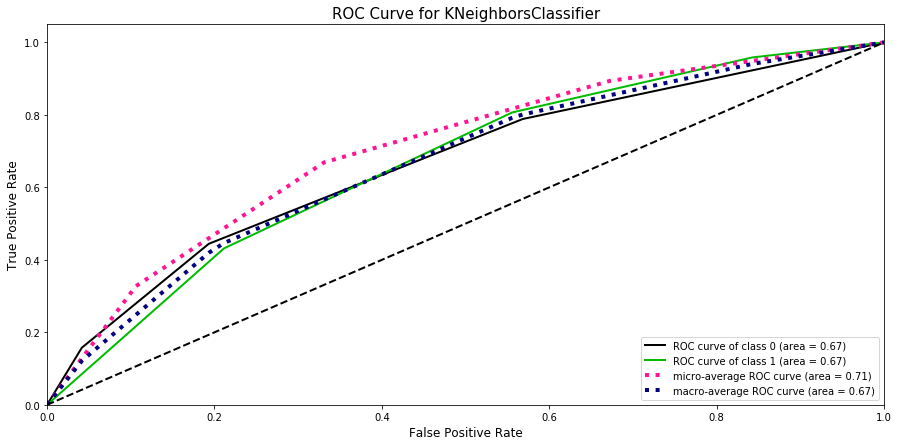

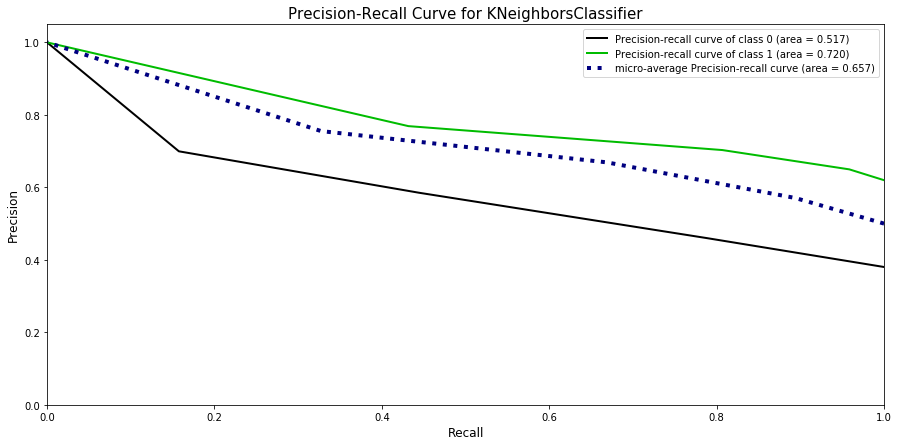

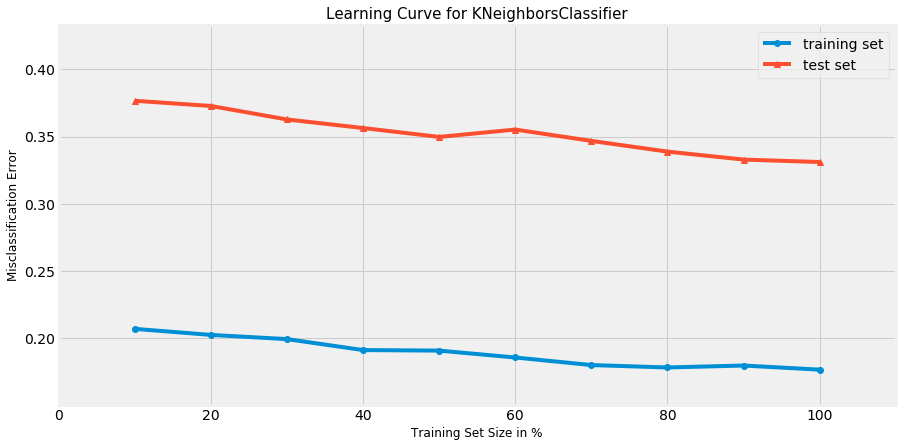

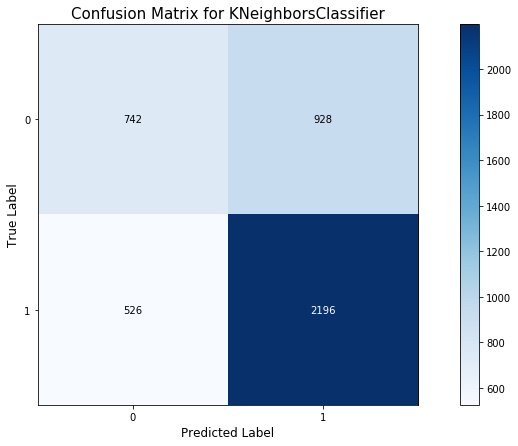

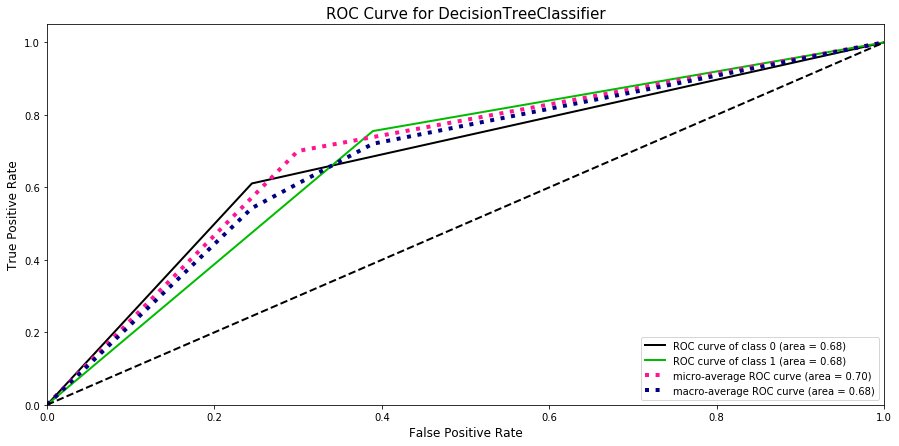

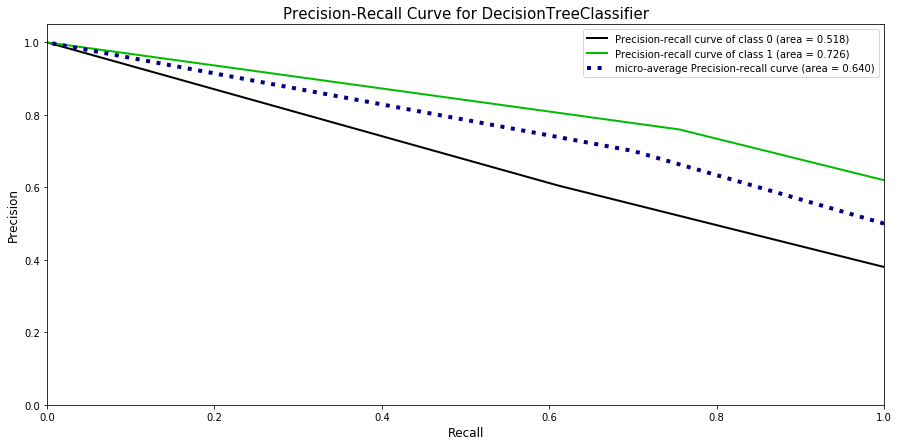

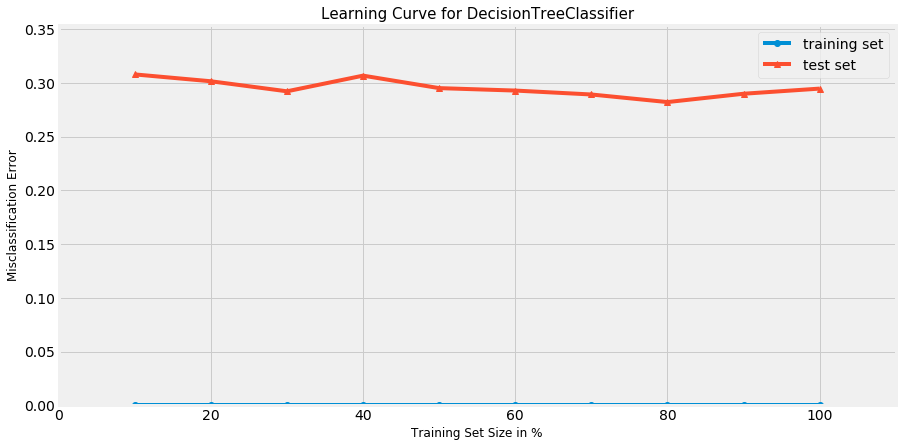

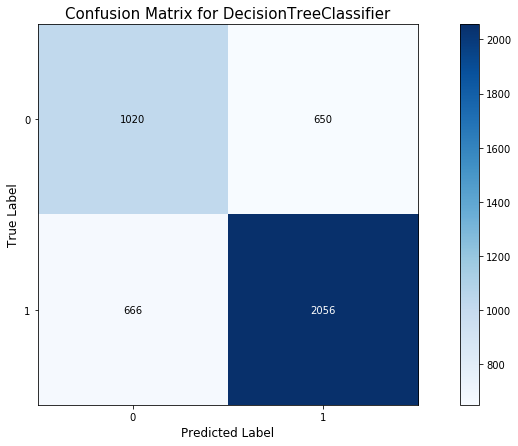

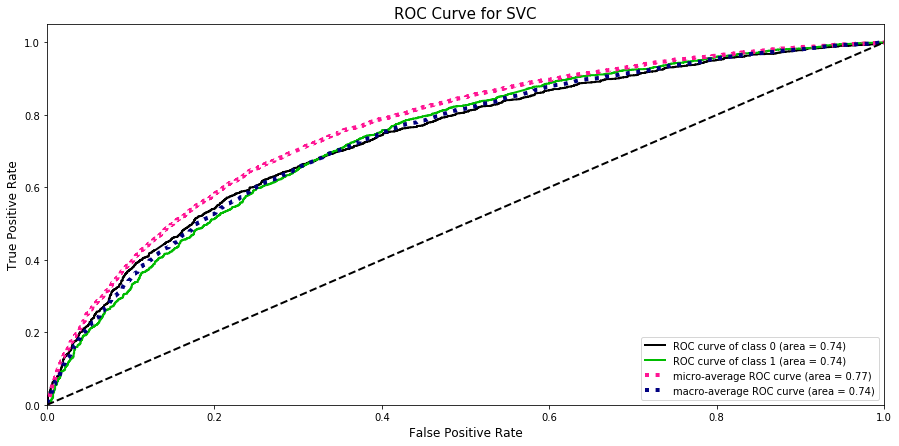

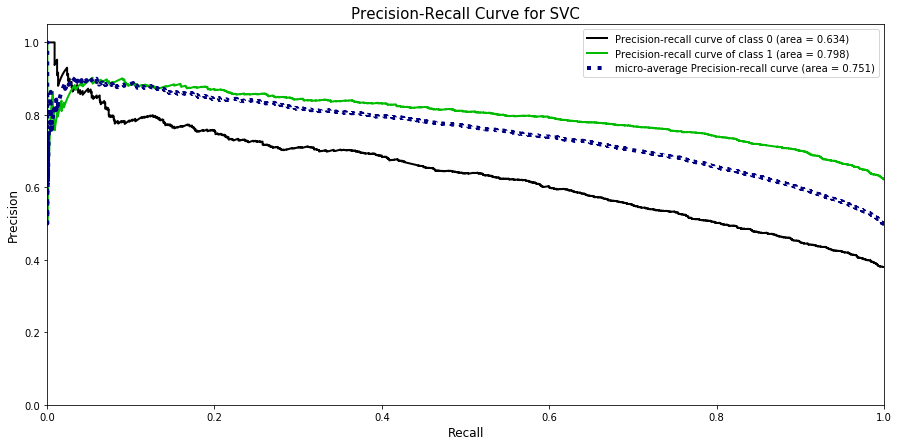

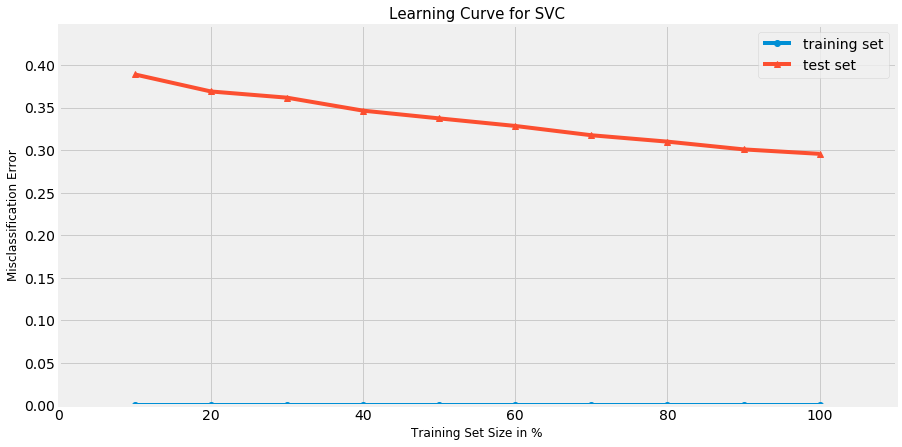

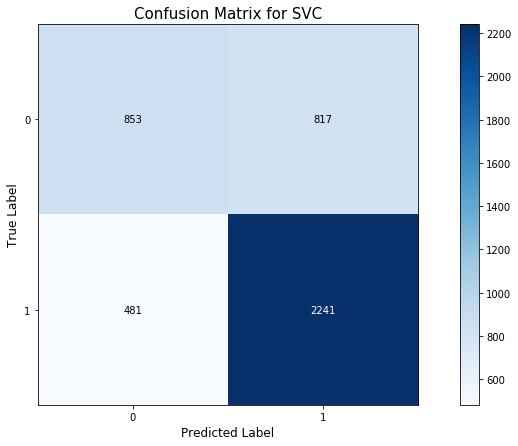

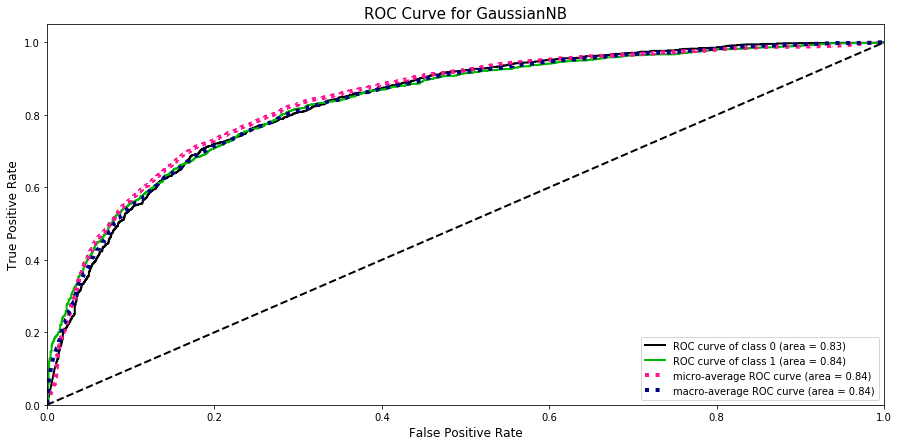

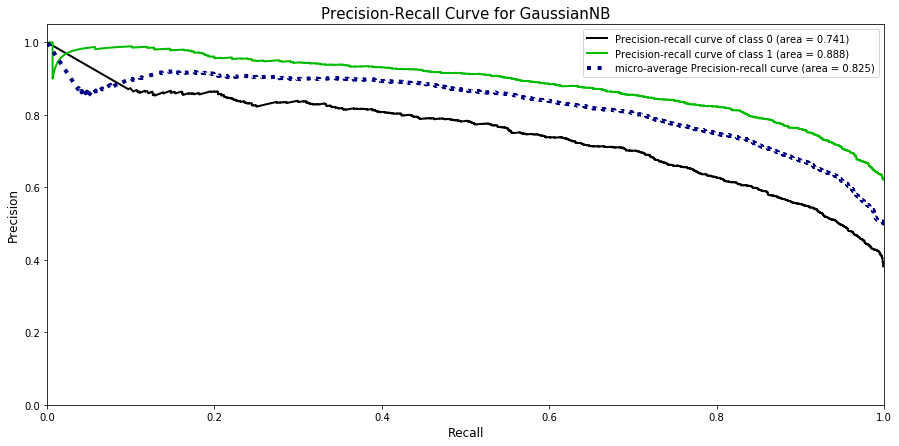

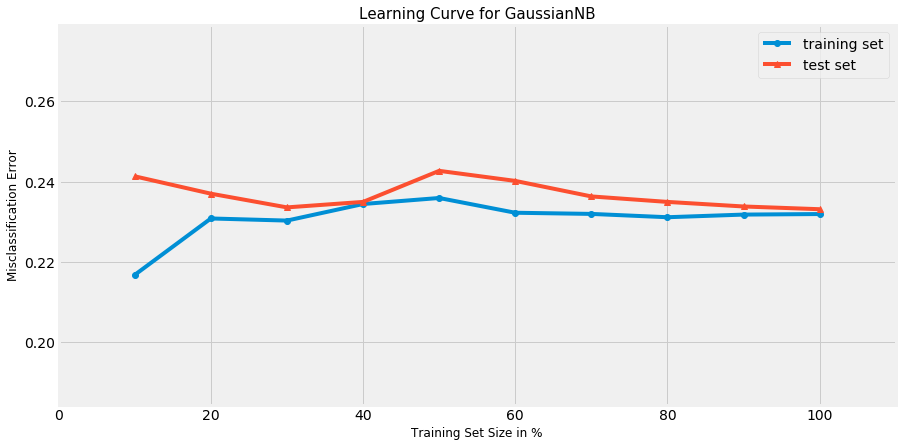

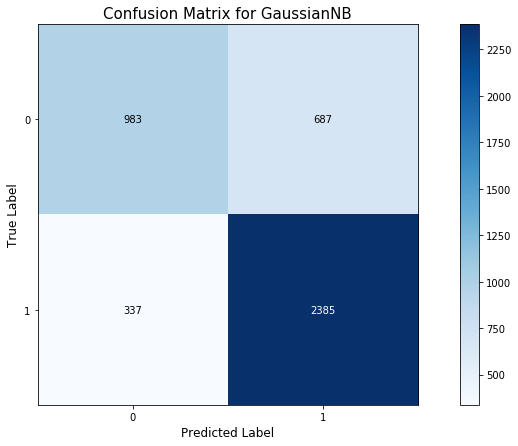

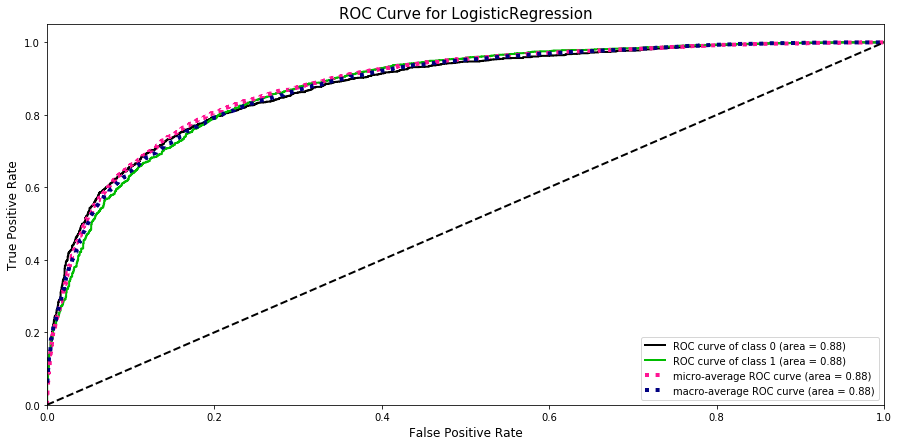

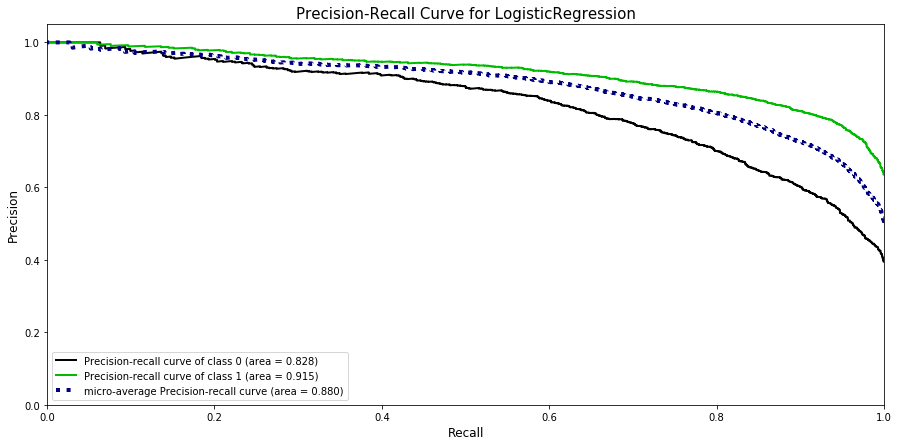

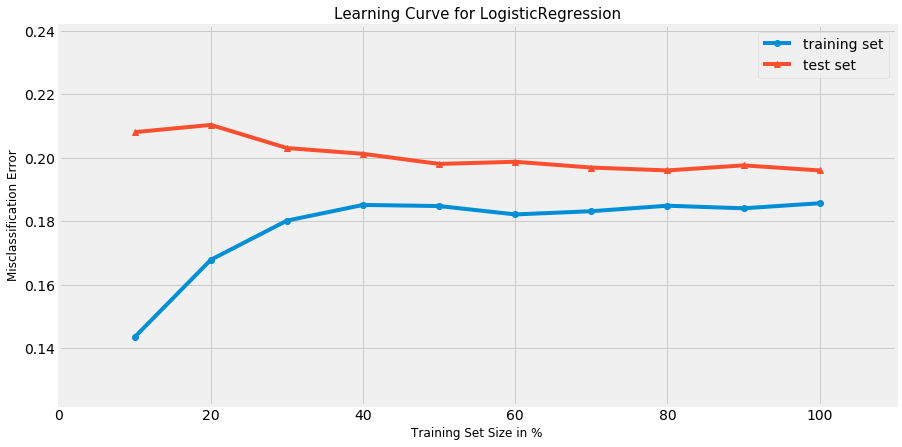

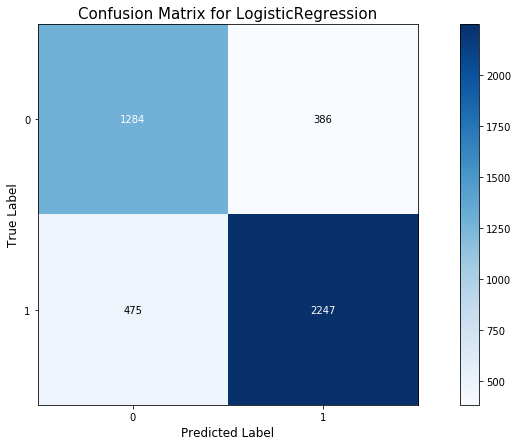

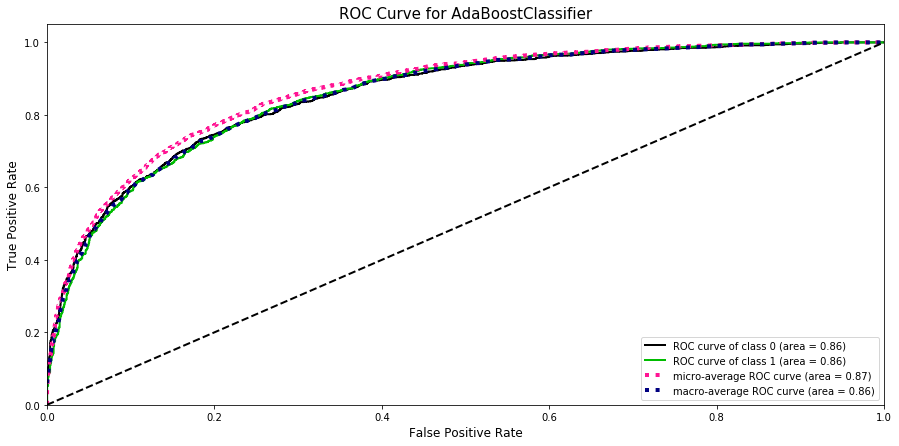

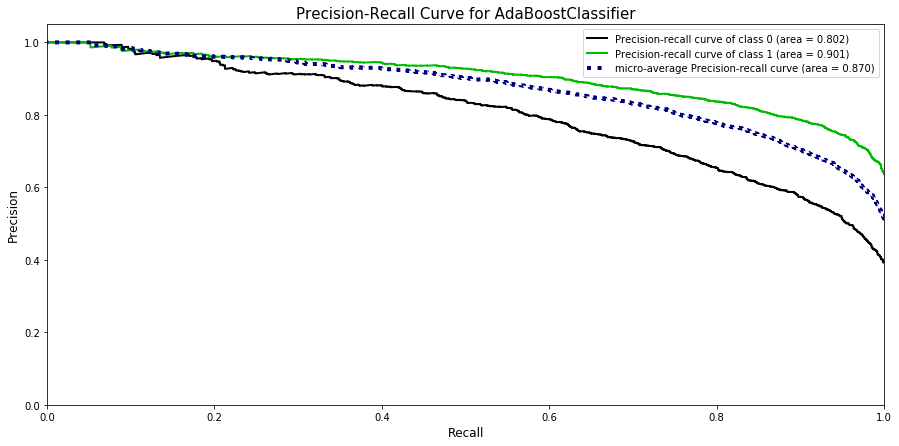

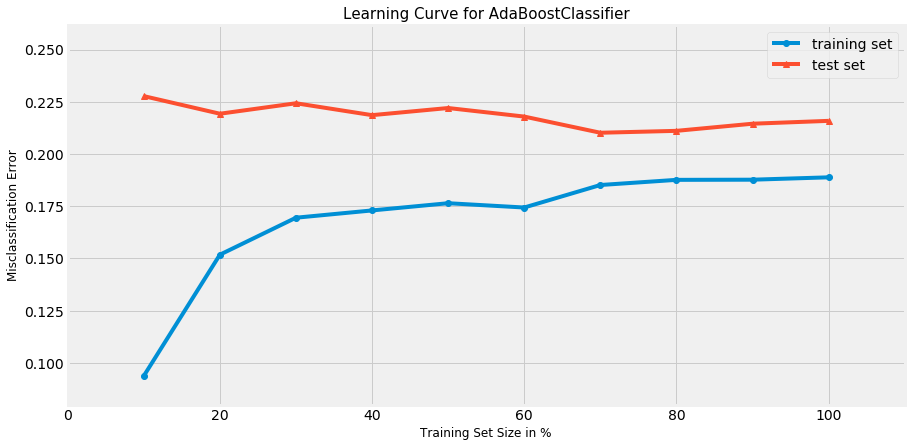

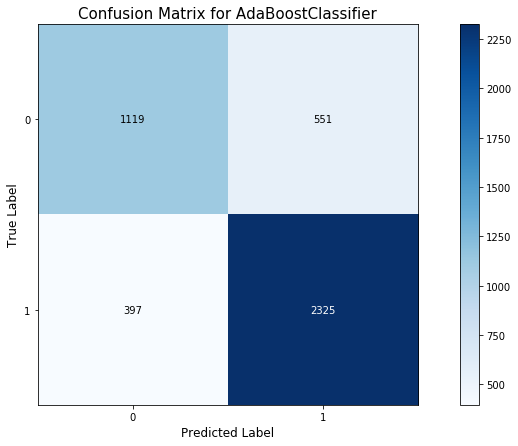

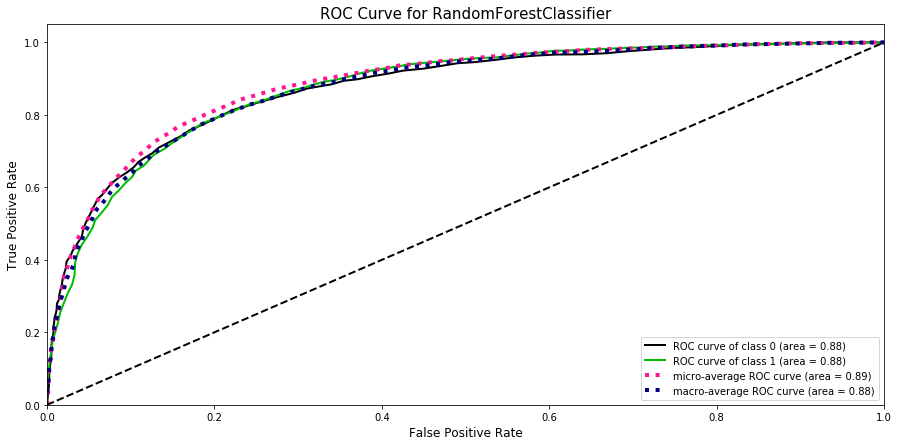

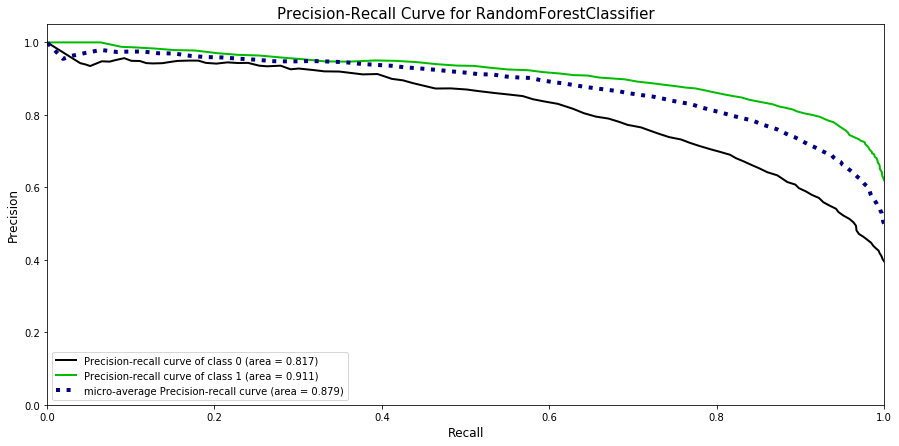

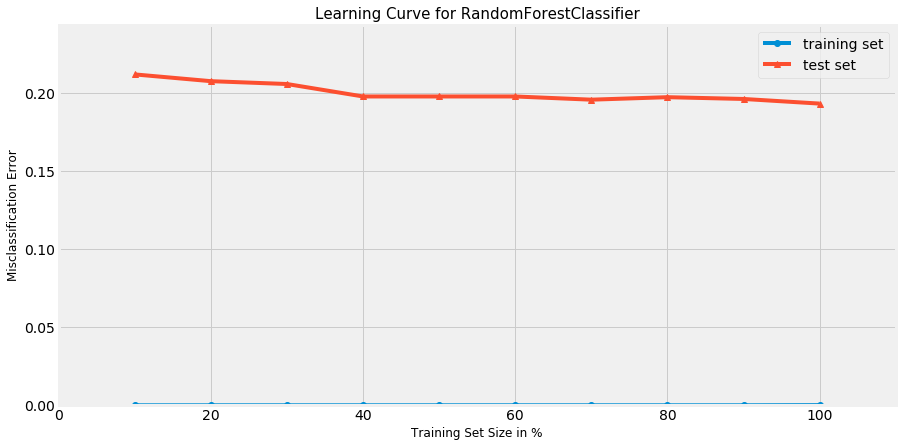

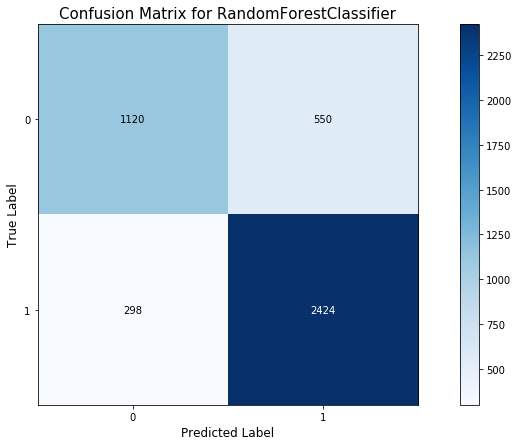

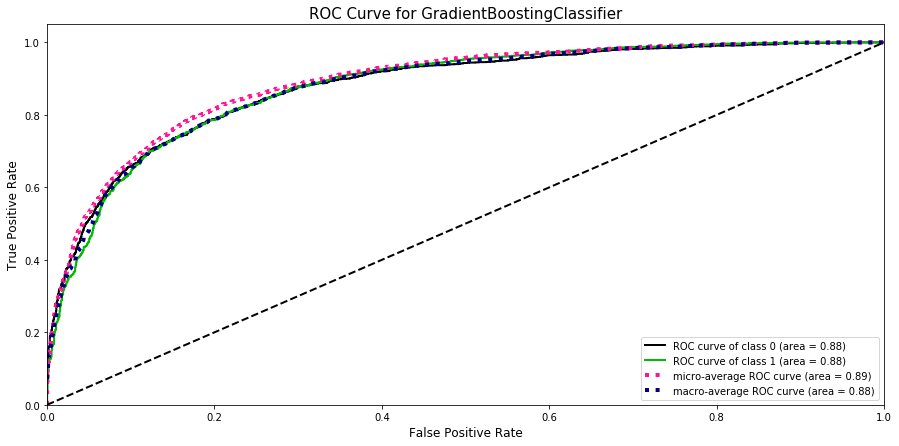

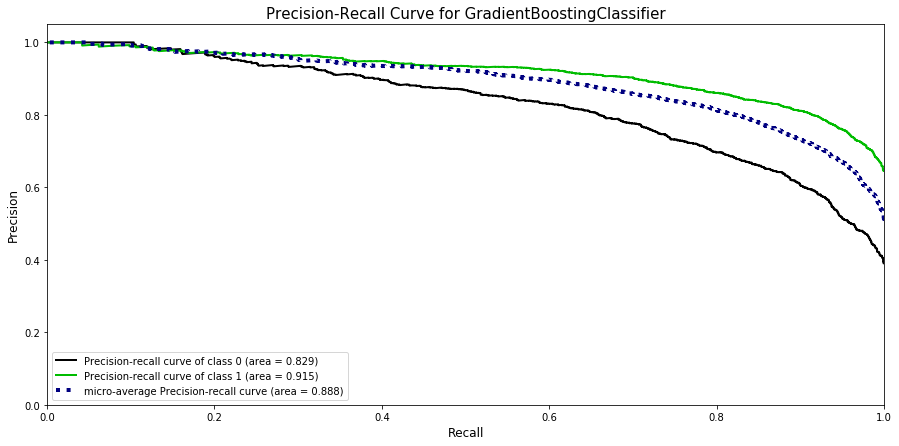

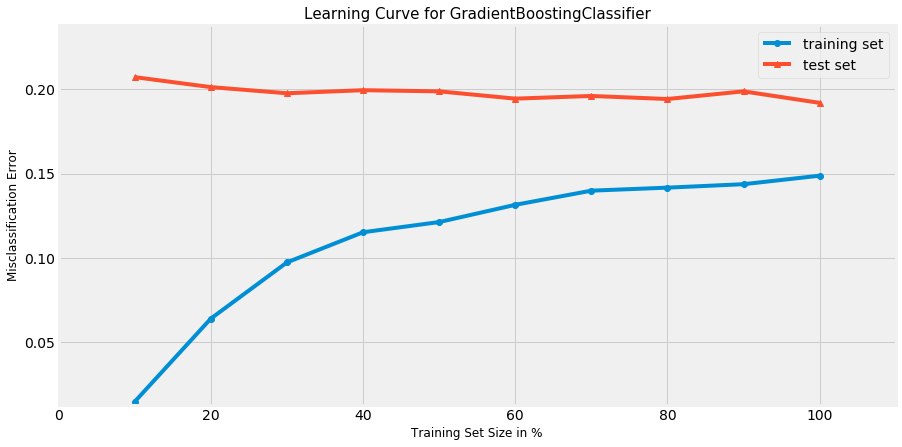

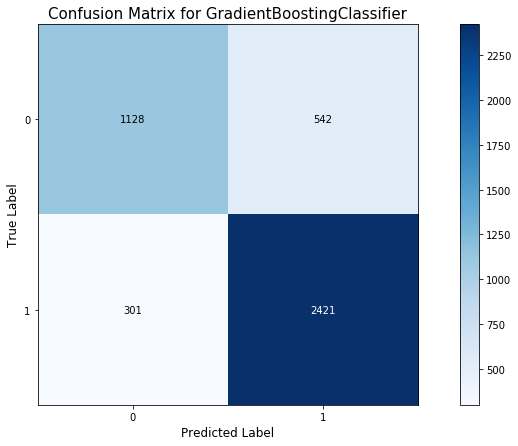

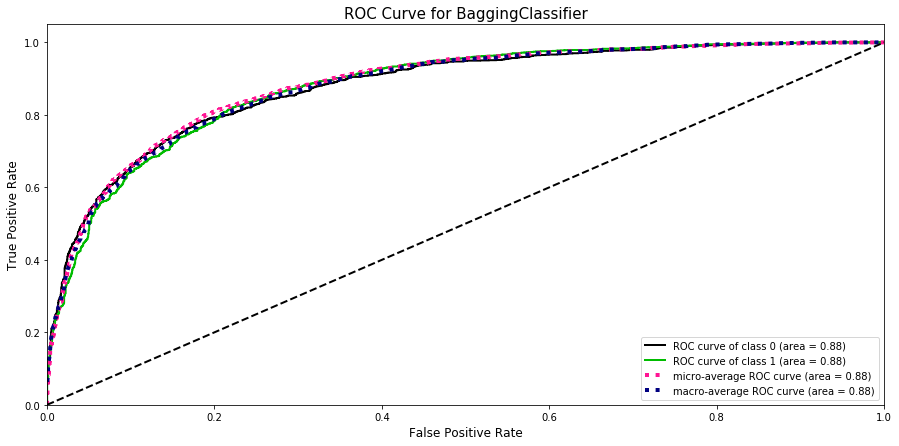

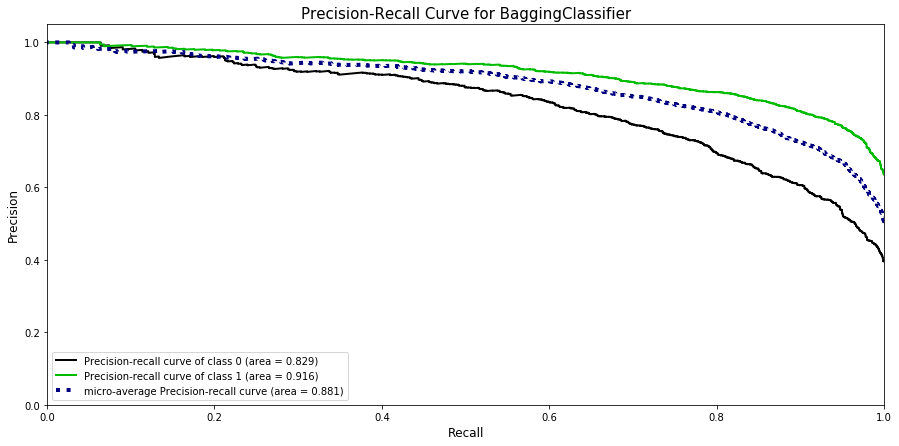

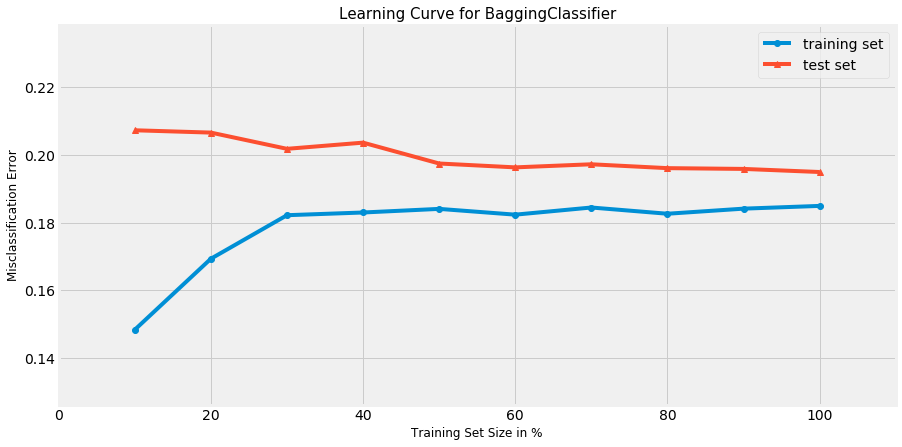

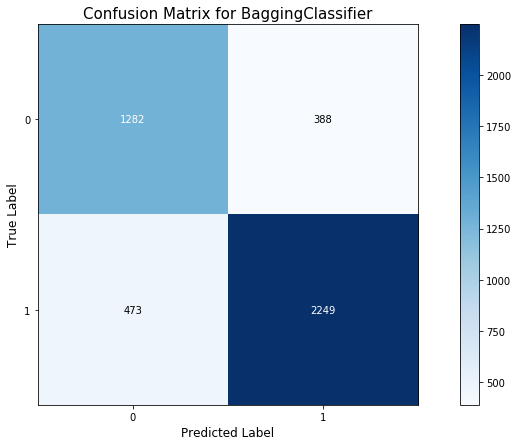

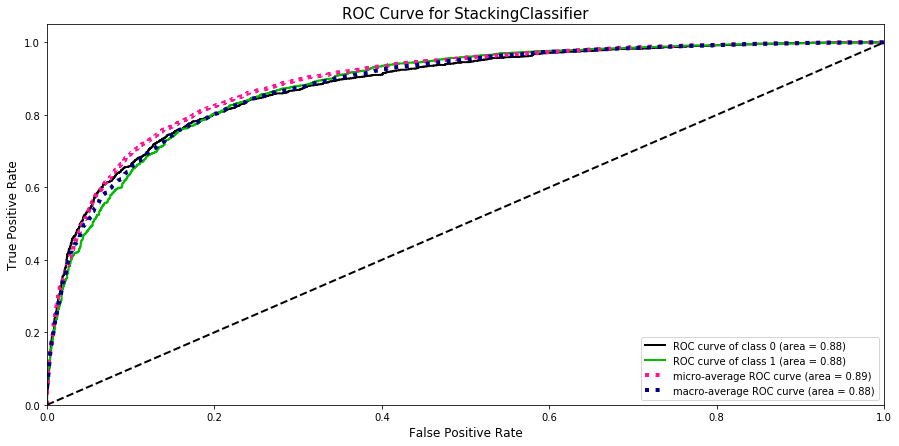

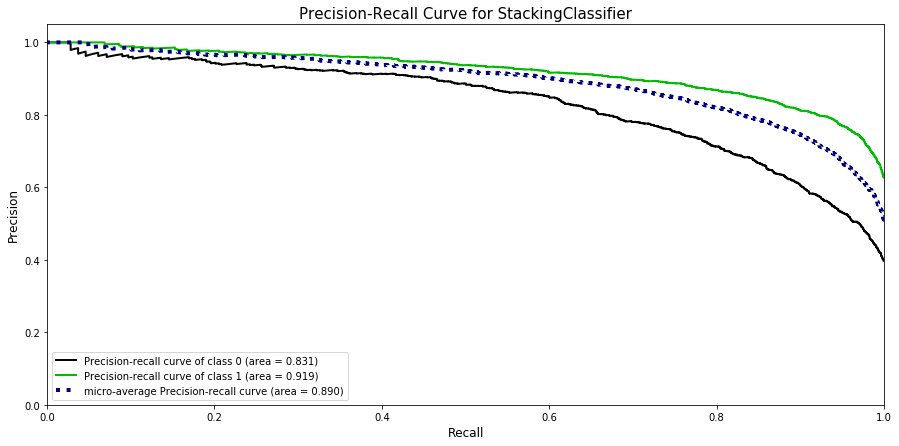

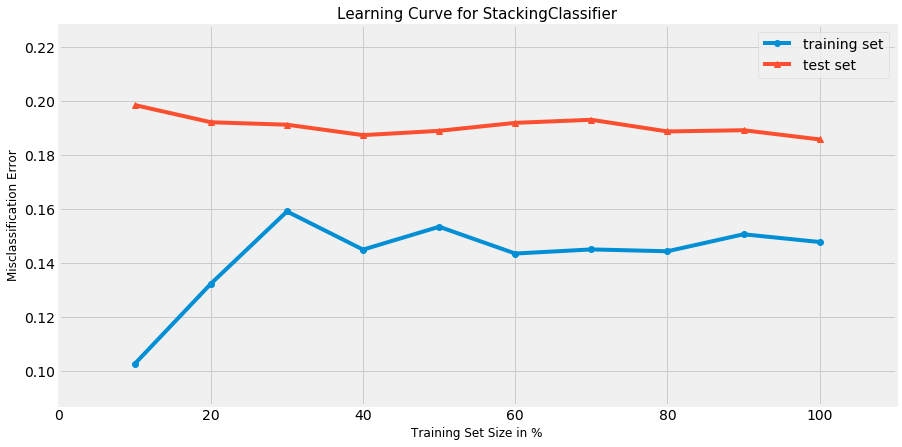

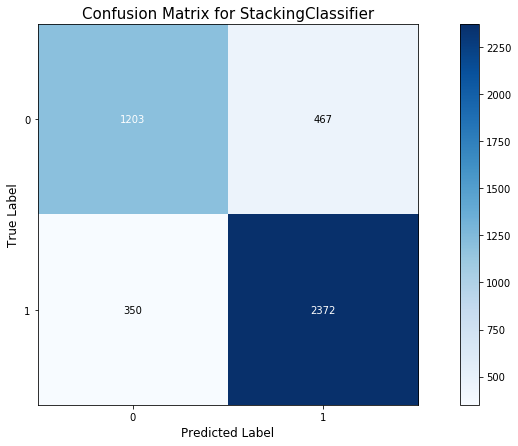

In [9]:
#predictions_entries = []

for model in models:
    model_name = model.__class__.__name__
    
    Y_train_predictions = cross_val_predict(
        model,
        X_train, 
        Y_train_1d,
        cv = cv_num, 
        method = 'predict_proba',
        n_jobs=-1
    )
    
    trained_model = model.fit(X_train, Y_train_1d)
    Y_test_predictions = trained_model.predict_proba(X_test)
    Y_test_binary_predictions = trained_model.predict(X_test)

    #ROC
    #train
    # Compute ROC curve and ROC area for each class
    fpr_train = dict()
    tpr_train = dict()
    roc_auc_train = dict()

    for i in range(classes_num):
        fpr_train[i], tpr_train[i], _ = roc_curve(Y_train_np_array[:, 0], Y_train_predictions[:, i])
        roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

    # Compute micro-average ROC curve and ROC area
    #we only need to provide probability estaimates of the positive class (i.e. Y_train_predictions[:, 1])
    fpr_train["micro"], tpr_train["micro"], _ = roc_curve(Y_train_np_array.ravel(), Y_train_predictions[:, 1].ravel())
    roc_auc_train["micro"] = auc(fpr_train["micro"], tpr_train["micro"])
    
    #test
    # Compute ROC curve and ROC area for each class
    fpr_test = dict()
    tpr_test = dict()
    roc_auc_test = dict()

    for i in range(classes_num):
        fpr_test[i], tpr_test[i], _ = roc_curve(Y_test_np_array[:, 0], Y_test_predictions[:, i])
        roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

    # Compute micro-average ROC curve and ROC area
    #we only need to provide probability estaimates of the positive class (i.e. Y_train_predictions[:, 1])
    fpr_test["micro"], tpr_test["micro"], _ = roc_curve(Y_test_np_array.ravel(), Y_test_predictions[:, 1].ravel())
    roc_auc_test["micro"] = auc(fpr_test["micro"], tpr_test["micro"])
    
    #plot roc curve
    #this manually plots roc curve train vs. test
    #line_weight_num = 2.5

    #plt.figure(figsize=fig_size_tuple)
    #plt.plot(fpr_test[1], tpr_test[1], color='red',
    #         lw = line_weight_num, label='ROC curve - Test (area = %0.3f)' % roc_auc_test[1])
    #plt.plot(fpr_train[1], tpr_train[1], color='darkorange',
    #         lw = line_weight_num, label='ROC curve - Train (area = %0.3f)' % roc_auc_train[1])
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    #plt.xlabel('False Positive Rate', fontsize=label_fontsize_num)
    #plt.ylabel('True Positive Rate', fontsize=label_fontsize_num)
    #plt.title('Receiver operating characteristic for ' + model_name, fontsize=title_fontsize_num)
    #plt.legend(loc="lower right")
    #plt.show()
    
    #uses scikit-plot instead of plotting manually
    plot_roc(Y_test, Y_test_predictions, 
            figsize=fig_size_tuple, title_fontsize=title_fontsize_num, text_fontsize=10, title='ROC Curve for ' + model_name)
    plt.xlabel('False Positive Rate', fontsize=label_fontsize_num)
    plt.ylabel('True Positive Rate', fontsize=label_fontsize_num)
    plt.show()
    
    
    #Precision-Recall
    #average precision-recall score
    average_precision_train = average_precision_score(Y_train, Y_train_predictions[:, 1])
    average_precision_test = average_precision_score(Y_test, Y_test_predictions[:, 1])
    
    #rint('Average train precision-recall score: {0:0.3f}'.format(average_precision_train))
    #rint('Average test precision-recall score: {0:0.3f}'.format(average_precision_test))
    
    #calculate precision recall curve
    precision_train = {}
    precision_test = {}
    recall_train = {}
    recall_test = {}
    
    precision_train, recall_train, _ = precision_recall_curve(Y_train_np_array.ravel(), Y_train_predictions[:, 1].ravel())
    precision_test, recall_test, _ = precision_recall_curve(Y_test_np_array.ravel(), Y_test_predictions[:, 1].ravel())
    
    #plot preciision-recall curve
    #this manually plots precision-recall curve train vs. test
    #plt.figure(figsize=fig_size_tuple)
    #plt.step(recall_train, precision_train, where='post', color='darkblue', 
    #         label='Precision-Recall Curve - Train (score = %0.3f)' % average_precision_train)
    #plt.step(recall_test, precision_test, where='post', color='lightblue', 
    #         label='Precision-Recall Curve - Test (score = %0.3f)' % average_precision_test)
    #plt.xlabel('Recall', fontsize=label_fontsize_num)
    #plt.ylabel('Precision', fontsize=label_fontsize_num)
    #plt.ylim([0.0, 1.05])
    #plt.xlim([0.0, 1.0])
    #plt.title(
    #    'Precision-Recall Curve for' + model_name, fontsize=title_fontsize_num)
    #plt.legend(loc="lower right")
    #plt.show()
    
    #this plots a shitty precision recall curve that can't really be modified visually
    #so don't use it unless if you have to
    #disp = plot_precision_recall_curve(model, X_test, Y_test)
    #disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision_test))
    
    #uses scikit-plot instead of plotting manually
    plot_precision_recall(Y_test, Y_test_predictions, 
                          figsize=fig_size_tuple, title_fontsize=title_fontsize_num, text_fontsize=10, title='Precision-Recall Curve for ' + model_name)
    plt.xlabel('Recall', fontsize=label_fontsize_num)
    plt.ylabel('Precision', fontsize=label_fontsize_num)
    plt.show()
    
    #plot learning curve
    #this one uses scikitplot to plot a usable learning curve
    #unfortunately we can't really choose a misclassification error for the scoring, so we use F2 instead...not ideal but oh well
    #plot_learning_curve(model, X_test, Y_test_1d, cv = cv_num, random_state = random_state_num, 
    #                    scoring = f2_scorer,
    #                    figsize=fig_size_tuple, title_fontsize=title_fontsize_num, text_fontsize=10, title='Learning Curve for ' + model_name)
    #plt.show()
    
    #this one uses mlxtend to plot a better learning curve
    #this is better because it offers misclassification error for the scoring, so more useful
    plt.figure(figsize=fig_size_tuple)
    plot_learning_curves(X_train, Y_train_1d, X_test, Y_test_1d, model)
    plt.title('Learning Curve for ' + model_name, fontsize=title_fontsize_num)
    plt.xlabel('Training Set Size in %', fontsize=label_fontsize_num)
    plt.ylabel('Misclassification Error', fontsize=label_fontsize_num)
    plt.show()
    
    
    #confusion matrices
    plot_confusion_matrix(Y_test, Y_test_binary_predictions,
                         figsize=fig_size_tuple, title_fontsize=title_fontsize_num, text_fontsize=10, title='Confusion Matrix for ' + model_name)
    plt.xlabel('Predicted Label', fontsize=label_fontsize_num)
    plt.ylabel('True Label', fontsize=label_fontsize_num)
    plt.show()

    
    #decision regions
    #not needed at this time, we need to reduce dimensions somehow in order to use decision trees in a useful manner


# References

Code for this project is either directly from (with some modification), or inspired by, but not limited to the following sources:

* Stacking Ensemble Method: https://towardsdatascience.com/stacking-made-easy-with-sklearn-e27a0793c92b
* Model Benchmarking: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
* Model Benchmarking (Example Code): https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb
* SciKit-Learn API Reference: https://scikit-learn.org/stable/modules/classes.html
* Ensemble Methods: https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205
* Respective API Reference for each package used

* Hyperparameter Tuning:
    * https://scikit-learn.org/stable/modules/grid_search.html
    * https://www.kaggle.com/tboyle10/hyperparameter-tuning
    * https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5
    * https://towardsdatascience.com/hyperparameter-tuning-c5619e7e6624
    * https://medium.com/@mandava807/cross-validation-and-hyperparameter-tuning-in-python-65cfb80ee485
    * http://www.davidsbatista.net/blog/2018/02/23/model_optimization/
    * https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search
    * https://chrisalbon.com/machine_learning/model_selection/hyperparameter_tuning_using_grid_search/
    * https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html
    * https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35
    * https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
    * https://www.datacareer.ch/blog/parameter-tuning-in-gradient-boosting-gbm-with-python/
    * https://www.kaggle.com/c/home-credit-default-risk/discussion/60657